# Anistropy Test

We will alter the ra and dec from every second event in the run to come from a similar patch of the sky (shrink sampled values by 100, then add constants of ra=2 and dec=1 to concentrate events around there). We will then test both models and check which way the Bayes Factor swings.

In [36]:
import bilby as bb
import gwpopulation as gwpop
import matplotlib.pyplot as plt
import pandas as pd
import jax
from bilby.core.prior import PriorDict, Uniform
import jax_healpy as hp
gwpop.set_backend("jax")

xp = gwpop.utils.xp

%matplotlib inline

# Load Posteriors
Need to remove BHNS events as they ruin the likelihood

In [77]:
Posteriors = list()
import pickle

# Load the pickled list of dictionaries
with open("O3a_FINAL_parameter_posteriors.pkl", "rb") as f:
    raw_event_data = pickle.load(f)

# Convert each event's dictionary into a DataFrame
for event in raw_event_data:
    # Remove the event name key — we'll store it as metadata instead
    event_name = event.pop("event", None)
    df = pd.DataFrame(event)
    df.attrs["event"] = event_name  # Store event label as metadata
    Posteriors.append(df)

with open("O3b_FINAL_parameter_posteriors.pkl", "rb") as f:
    raw_event_data = pickle.load(f)

# Convert each event's dictionary into a DataFrame
for event in raw_event_data:
    # Remove the event name key — we'll store it as metadata instead
    event_name = event.pop("event", None)
    df = pd.DataFrame(event)
    df.attrs["event"] = event_name  # Store event label as metadata
    Posteriors.append(df)


# Suppose your list of DataFrames is called `dataframes`
Posteriors_filtered = [df for df in Posteriors if len(df["mass_1"]) >= 2000]


del Posteriors_filtered[67]
del Posteriors_filtered[53]
del Posteriors_filtered[46]
del Posteriors_filtered[26]

#print(Posteriors_filtered[25]['full_event'])
#for i, df in enumerate(Posteriors_filtered):
#    event_name = df.attrs.get("event", f"unnamed_event_{i}")
#    print(f"{i}: {event_name}")

for i in range(0, len(Posteriors_filtered)):
    del Posteriors_filtered[i]["full_event"] 

for i in range(1, len(Posteriors_filtered), 5):  # start from 1, step by 2: every second event
    df = Posteriors_filtered[i]
    # Modify RA and Dec columns
    df['ra'] = -df['ra'] / 5 + 2.0
    df['dec'] = -df['dec']  / 5 + 1.0

print(len(Posteriors_filtered))

67


# Load Injections

In [18]:
from gwpopulation_pipe.vt_helper import load_injection_data
import h5py

def load_injection_data_with_sky(vt_file, ifar_threshold=1, snr_threshold=10):
    # Call your existing standard function to get the injections dict (VTData or dict)
    injections = load_injection_data(vt_file, ifar_threshold, snr_threshold)
    
    # Open the file again to extract sky location arrays if present
    with h5py.File(vt_file, "r") as ff:
        # Try common keys for sky position in injections or events group
        ra = None
        dec = None
        if "injections" in ff and "right_ascension" in ff["injections"]:
            ra = xp.array(ff["injections"]["right_ascension"][()])
            dec = xp.array(ff["injections"]["declination"][()])
        elif "events" in ff and "right_ascension" in ff["events"].dtype.names:
            ra = xp.array(ff["events"]["right_ascension"][()])
            dec = xp.array(ff["events"]["declination"][()])
        
        # If found, apply the same selection mask as used for injections (usually `found`)
        # This assumes you have access to the `found` mask, otherwise extract it again here:
        # For now let's assume the selection mask is the same length as injections.mass_1
        
        if ra is not None and dec is not None:
            # Match the length by slicing or by assuming same order as injections.mass_1
            n = len(injections.mass_1)
            injections.ra = ra[:n]
            injections.dec = dec[:n]
        else:
            print("Warning: RA/DEC not found in the injection file.")

    return injections

injections = load_injection_data_with_sky(
    "/data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12.hdf5",
    #"/data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12-1238166018-15843600.hdf5",
    ifar_threshold=1.0,
    snr_threshold=10.0
)

injection_dict = dict(injections)
injection_dict["ra"] = injections.ra
injection_dict["dec"] = injections.dec

print(injection_dict)

11:39 bilby INFO    : Loading VT data from /data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12.hdf5.


{'prior': Array([1.39111379e-05, 1.86462070e-04, 7.85029319e-05, ...,
       6.11679944e-04, 7.53873001e-05, 1.00616629e-04], dtype=float64), 'total_generated': 73957576, 'analysis_time': 0.9110190889040992, 'mass_1': Array([91.0051  ,  4.309117, 49.56017 , ...,  8.86458 , 36.64523 ,
       31.180185], dtype=float32), 'mass_1_detector': None, 'mass_ratio': Array([0.65772885, 0.85667926, 0.9848587 , ..., 0.9066763 , 0.7954306 ,
       0.7844692 ], dtype=float32), 'a_1': Array([0.98207206, 0.9192754 , 0.8060329 , ..., 0.7623293 , 0.9208208 ,
       0.116249  ], dtype=float32), 'a_2': Array([0.38297835, 0.20714064, 0.8374939 , ..., 0.7935884 , 0.15089767,
       0.17788795], dtype=float32), 'cos_tilt_1': Array([ 0.79286975, -0.03908841, -0.46724546, ...,  0.06254739,
       -0.05229687, -0.6200175 ], dtype=float32), 'cos_tilt_2': Array([ 0.9740226 , -0.32460937, -0.28301463, ..., -0.04667544,
       -0.7070246 , -0.19870013], dtype=float32), 'chi_eff': None, 'chi_p': None, 'redshift': Arr

# Define sky model in terms of 12 pixels and 3 Euler angles

In [26]:
from jax.scipy.spatial.transform import Rotation as R

Npix = 12

def sky_shape_model(dataset, 
                    w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, a, b, c):
    ra = dataset["ra"]
    dec = dataset["dec"]

    theta = xp.pi / 2 - dec
    phi = ra

    theta_flat = theta.flatten()
    phi_flat = phi.flatten()

    vec = hp.ang2vec(theta_flat, phi_flat)

    rot = R.from_euler("ZYZ", [a, b, c], degrees=False)
    vec_rot = rot.apply(vec)

    theta_rot, phi_rot = hp.vec2ang(vec_rot)
    pix = hp.ang2pix(1, theta_rot, phi_rot)

    weights_partial = xp.array([w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10])
    w_N = 1 - xp.sum(weights_partial)
    weights = xp.concatenate([weights_partial, xp.array([w_N])])

    probs_flat = weights[pix] * 4*xp.pi # Think about this more!!!
    probs = probs_flat.reshape(ra.shape)

    return probs

class SkyShapeModel:
    variable_names = [f"w_{i}" for i in range(Npix - 1)]

    def __init__(self, dataset, **kwargs):
        # Just call the function and return the result
        # This return is used by gwpopulation's metaclass magic
        return sky_shape_model(dataset, **kwargs)

# Define Priors
Need to find good numbers and replace with delta functions for all but sky model.

# Firstly, create joint prior:
$$ p \left(\textbf{a} | \text{ANISO}\right) \propto R^{-\left(\frac{2 N_{\text{pix}}-1}{2}\right)} = \left(\frac{4 \pi}{N_{\text{pix}}} \sum_{i}^{N_{\text{pix}}} a_{i}\right)^{-\frac{(2 N_{\text{pix}}-1)}{2}}$$

In [27]:
import numpy as np
from bilby.core.prior.joint import BaseJointPriorDist, JointPrior

from bilby.core.prior.dict import DirichletPriorDict, ConditionalPriorDict
from bilby.core.prior import PriorDict, JointPrior

Npix = 12

# Create the DirichletPriorDict for Npix weights (Npix-1 parameters)
dirichlet_prior_dict = DirichletPriorDict(n_dim=Npix, label="w_")

# This gives you a PriorDict-like object with keys: "w_0", "w_1", ..., "w_10" (Npix-1 elements)
print(dirichlet_prior_dict.keys())  # e.g. dict_keys(['w_0', 'w_1', ..., 'w_10'])




dict_keys(['w_0', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 'w_7', 'w_8', 'w_9', 'w_10'])


In [81]:
from bilby.core.prior import DeltaFunction, Exponential, Uniform, Sine, PowerLaw

#priors = PriorDict()
priors = ConditionalPriorDict(dirichlet_prior_dict)

#for key in dirichlet_prior_dict:
#    # Each key corresponds to one stick-breaking param
#    priors[key] = dirichlet_prior_dict[key]


# mass
priors["alpha"] = Uniform(minimum=-2, maximum=4, latex_label="$\\alpha$")
priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
priors["mmin"] = Uniform(minimum=2, maximum=2.5, latex_label="$m_{\\min}$")
priors["mmax"] = Uniform(minimum=80, maximum=100, latex_label="$m_{\\max}$")
priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
priors["mpp"] = Uniform(minimum=10, maximum=50, latex_label="$\\mu_{m}$")
priors["sigpp"] = Uniform(minimum=1, maximum=10, latex_label="$\\sigma_{m}$")
priors["gaussian_mass_maximum"] = 100
# spin
priors["amax"] = 1
priors["alpha_chi"] = Uniform(minimum=1, maximum=6, latex_label="$\\alpha_{\\chi}$")
priors["beta_chi"] = Uniform(minimum=1, maximum=6, latex_label="$\\beta_{\\chi}$")
priors["xi_spin"] = Uniform(minimum=0, maximum=1, latex_label="$\\xi$")
priors["sigma_spin"] = Uniform(minimum=0.3, maximum=4, latex_label="$\\sigma$")
# Cosmology
priors["lamb"] = Uniform(minimum=-1, maximum=10, latex_label="$\\lambda_{z}$")

## --- Sky model: pixel weights ---
#for i in range(1, 13):
 #   priors[f"a_{i}"] = Exponential(mu=1.0, latex_label=f"a_{i}")

# --- Sky model: Euler angles ---
# alpha and gamma: uniform over [0, 360)
priors["a"] = Uniform(minimum=0.0, maximum=2*xp.pi, latex_label = "$\\alpha_{e}$")
priors["c"] = Uniform(minimum=0.0, maximum=2*xp.pi, latex_label = "$\\gamma_{e}$")

#beta: sine prior over [0, pi] to ensure isotropy in inclination
priors["b"] = Sine(minimum=0.0, maximum=xp.pi, latex_label = "$\\beta_{e}$")

# Define combined model, selection function, and likelihood

In [30]:
def convert_vtdata_to_float64(vtdata):
    for key in vtdata.keys():
        val = vtdata[key]
        if isinstance(val, (xp.ndarray,)):
            vtdata[key] = val.astype(xp.float64)
    return vtdata

# Usage
injections = convert_vtdata_to_float64(injection_dict)

In [82]:
from gwpopulation.experimental.jax import JittedLikelihood, NonCachingModel
from gwpopulation.experimental.cosmo_models import CosmoModel
from bilby.hyper.model import Model

model = NonCachingModel(
    model_functions=[
        gwpop.models.mass.two_component_primary_mass_ratio,
        gwpop.models.spin.iid_spin,
        gwpop.models.redshift.PowerLawRedshift(cosmo_model="Planck15"),
        sky_shape_model,
    ],
)

vt = gwpop.vt.ResamplingVT(model=model, data=injections, n_events=len(Posteriors_filtered))

likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=Posteriors_filtered,
    hyper_prior=model,
    selection_function=vt,
    max_samples = 1000,
)

14:18 bilby INFO    : No prior values provided, defaulting to 1.


# Test likelihood

In [83]:
parameters = priors.sample()
likelihood.parameters.update(parameters)
likelihood.log_likelihood_ratio()
%time print(likelihood.log_likelihood_ratio())
jit_likelihood = JittedLikelihood(likelihood)
jit_likelihood.parameters.update(parameters)
%time print(jit_likelihood.log_likelihood_ratio())
%time print(jit_likelihood.log_likelihood_ratio())

-403.1825248857609
CPU times: user 479 ms, sys: 131 ms, total: 610 ms
Wall time: 282 ms
-403.1825248857609
CPU times: user 16.7 s, sys: 979 ms, total: 17.7 s
Wall time: 6.88 s
-403.1825248857609
CPU times: user 8.72 ms, sys: 1.83 ms, total: 10.5 ms
Wall time: 4.07 ms


In [84]:
result = bb.run_sampler(
    likelihood=jit_likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=200,
    label="ANISO_5th",
    outdir = "ANISO_CHECKS_over5",
    sample="acceptance-walk",
    naccept=5,
    save="pkl",
)



14:18 bilby INFO    : Running for label 'ANISO_5th', output will be saved to 'ANISO_CHECKS_over5'
14:18 bilby INFO    : Analysis priors:
14:18 bilby INFO    : w_0=DirichletElement(order=0, n_dimensions=12, label='w_')
14:18 bilby INFO    : w_1=DirichletElement(order=1, n_dimensions=12, label='w_')
14:18 bilby INFO    : w_2=DirichletElement(order=2, n_dimensions=12, label='w_')
14:18 bilby INFO    : w_3=DirichletElement(order=3, n_dimensions=12, label='w_')
14:18 bilby INFO    : w_4=DirichletElement(order=4, n_dimensions=12, label='w_')
14:18 bilby INFO    : w_5=DirichletElement(order=5, n_dimensions=12, label='w_')
14:18 bilby INFO    : w_6=DirichletElement(order=6, n_dimensions=12, label='w_')
14:18 bilby INFO    : w_7=DirichletElement(order=7, n_dimensions=12, label='w_')
14:18 bilby INFO    : w_8=DirichletElement(order=8, n_dimensions=12, label='w_')
14:18 bilby INFO    : w_9=DirichletElement(order=9, n_dimensions=12, label='w_')
14:18 bilby INFO    : w_10=DirichletElement(order=10,

1it [00:00, ?it/s]

14:33 bilby INFO    : Written checkpoint file ANISO_CHECKS_over5/ANISO_5th_resume.pickle
14:34 bilby INFO    : Written checkpoint file ANISO_CHECKS_over5/ANISO_5th_resume.pickle
14:34 bilby INFO    : Rejection sampling nested samples to obtain 1526 posterior samples
14:34 bilby INFO    : Sampling time: 0:15:31.128628
14:34 bilby INFO    : Summary of results:
nsamples: 1526
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.380
ln_bayes_factor: -226.675 +/-  0.380



In [14]:
# Load the result file (replace with your actual filename)
result = bb.result.read_in_result('Full_tests/O3_ANISO_test_result.pkl')

# List of parameters to exclude
exclude_params = [
    "alpha", "beta", "mmin", "mmax", "lam", "mpp", "sigpp", "gaussian_mass_maximum",
    "amax", "alpha_chi", "beta_chi", "xi_spin", "sigma_spin", "lamb", "log_likelihood", "prior"
]

# Get the list of parameters to include in the corner plot
plot_params = [param for param in result.posterior.columns if param not in exclude_params]

# Make the corner plot
result.plot_corner()

# Show the plot
plt.show()

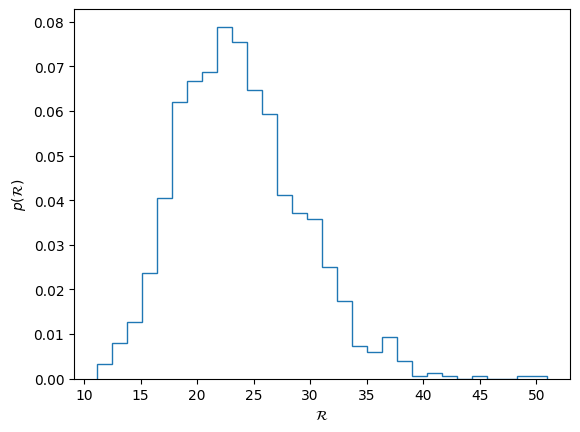

In [13]:
result = bb.result.read_in_result('Full_tests/one_location_test_ANISO_result.pkl')

rates = list()
for ii in range(len(result.posterior)):
    likelihood.parameters.update(dict(result.posterior.iloc[ii]))
    rates.append(float(likelihood.generate_rate_posterior_sample()))
result.posterior["rate"] = rates

plt.hist(rates, bins=30, histtype="step", density=True)
plt.xlabel("${\\cal R}$")
plt.ylabel("$p({\\cal R})$")
plt.show()
plt.close()

# Pixel Posteriors without angle correction

# Euler Angle Correction



In [14]:
import healpy as hp
import numpy as np
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

# Setup
Npix = 12
nside = hp.npix2nside(Npix)
npix = hp.nside2npix(nside)
pixel_area = hp.nside2pixarea(nside)  # steradians

n_samples = len(result.posterior)
pixel_rate_posteriors = np.zeros((n_samples, Npix))

# Get pixel center vectors in the model basis
vec_model = np.asarray(hp.pix2vec(nside, np.arange(Npix)))  # shape (3, 12)
vec_model = vec_model.T  # shape (12, 3)

# Loop through posterior samples
for i in tqdm(range(n_samples)):
    # Get sampled weights
    weights = [result.posterior[f"w_{j}"].iloc[i] for j in range(Npix - 1)]
    w_last = 1.0 - sum(weights)
    weights.append(w_last)
    weights = np.asarray(weights)

    # Total rate for this sample
    R_tot = result.posterior["rate"].iloc[i]
    rates_rotated = weights * R_tot

    # Normalize to rate density (Gpc⁻³ yr⁻¹ sr⁻¹)
    rate_density_rotated = rates_rotated / pixel_area

    # Euler angles
    alpha = result.posterior["a"].iloc[i]
    beta = result.posterior["b"].iloc[i]
    gamma = result.posterior["c"].iloc[i]

    # Build forward rotation (model -> celestial)
    rotation = R.from_euler("ZYZ", [alpha, beta, gamma], degrees=False)
    vec_celestial = rotation.inv().apply(vec_model)

    # Convert to spherical coordinates
    theta_new, phi_new = hp.vec2ang(vec_celestial.T)

    # Build rotated map
    map_rotated = np.zeros(npix)
    map_rotated[:Npix] = rate_density_rotated
    
    pix_indices = hp.vec2pix(nside, vec_celestial[:, 0], vec_celestial[:, 1], vec_celestial[:, 2])

    pixel_rate_posteriors[i, :] = 0.0
    for j, pix in enumerate(pix_indices):
        pixel_rate_posteriors[i, pix] += rates_rotated[j]


100%|██████████| 1116/1116 [00:00<00:00, 3012.30it/s]


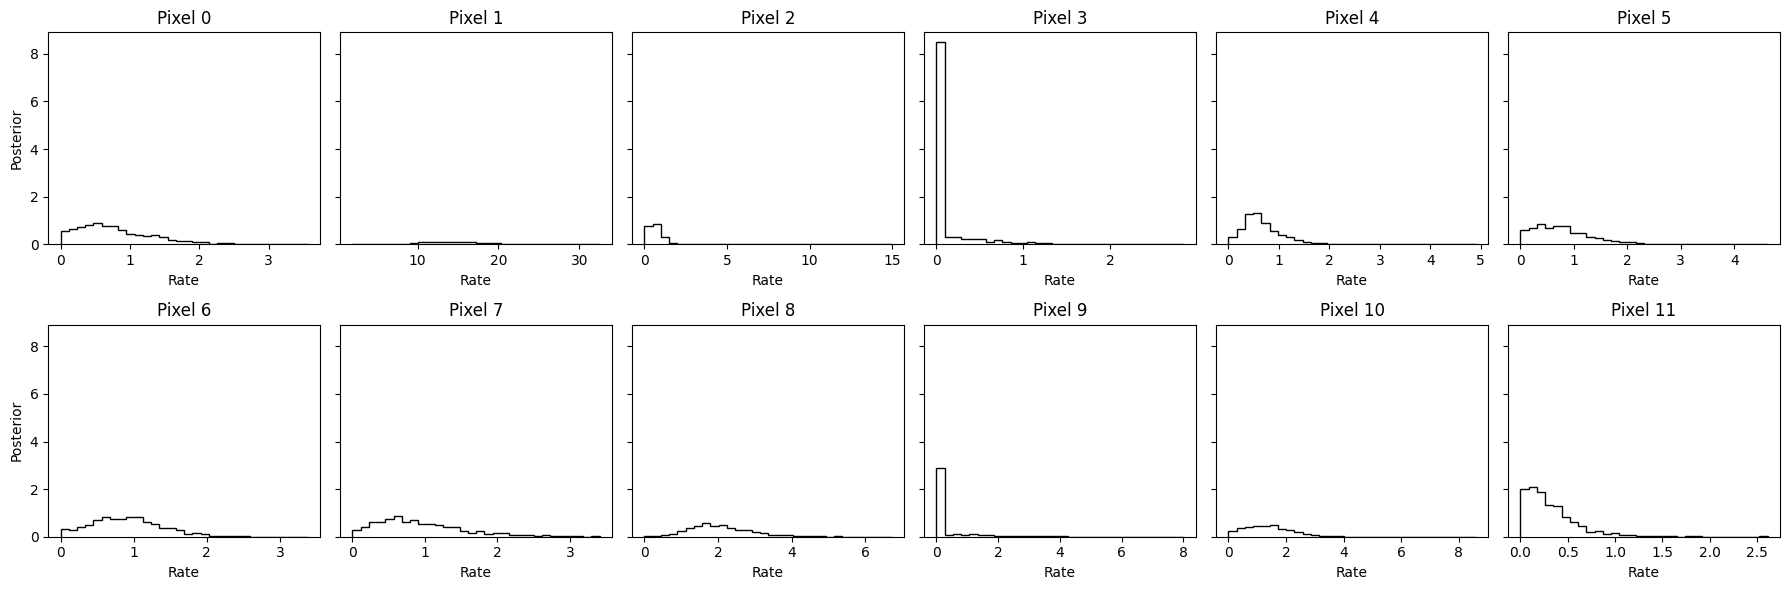

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharey=True)

for i in range(12):
    ax = axes[i // 6, i % 6]
    ax.hist(pixel_rate_posteriors[:, i], bins=30, histtype='step', color='black', density=True)
    ax.set_title(f"Pixel {i}")
    ax.set_xlabel("Rate")
    if i % 6 == 0:
        ax.set_ylabel("Posterior")

plt.tight_layout()
plt.show()


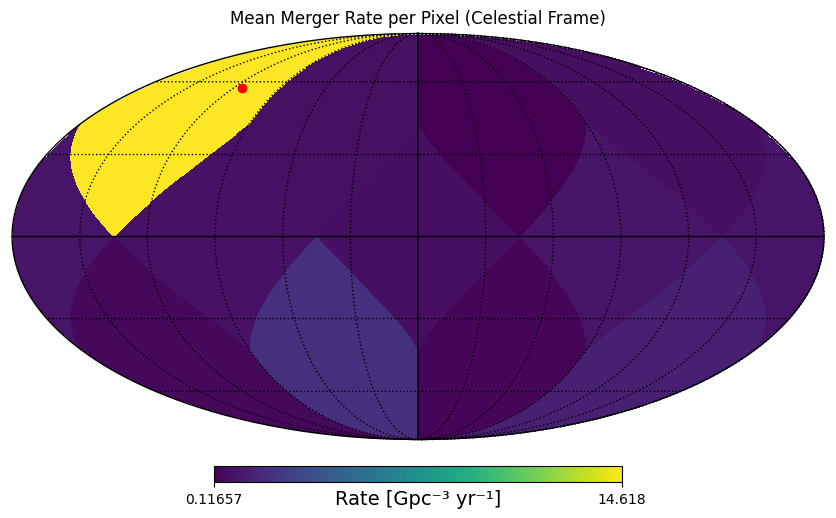

23.803768045929814


In [16]:
# Step 1: Mean rate in each pixel (celestial frame)
mean_rates = np.mean(pixel_rate_posteriors, axis=0)

# Step 2: Create full HEALPix map
nside = hp.npix2nside(12)
npix = hp.nside2npix(nside)
map_to_plot = np.full(npix, hp.UNSEEN)  # Fill all with unseen
map_to_plot[:12] = mean_rates           # Set only the 12 pixels we used

# Step 3: Mollweide plot
hp.mollview(
    map_to_plot,
    title="Mean Merger Rate per Pixel (Celestial Frame)",
    unit="Rate [Gpc⁻³ yr⁻¹]",
    cmap="viridis",
    #min=0,
    #max=np.max(mean_rates)
)
hp.projscatter(np.pi/2 - 1, 2, lonlat=False, c='red', marker='o', label='RA=2°, Dec=1°')
hp.graticule()
plt.show()

print(np.sum(mean_rates))

# Euler Correction with smoothing onto Nside=64 basis

100%|██████████| 1116/1116 [00:02<00:00, 386.03it/s]


23.803768045929814


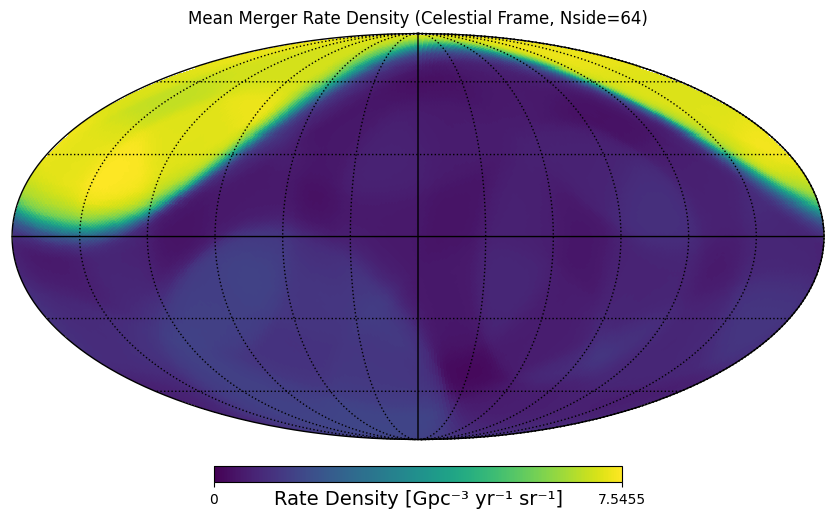

In [17]:
import healpy as hp
import numpy as np
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

# Parameters
nside_model = 1        # model basis (12 pixels)
nside_target = 64      # high-res common basis
npix_model = hp.nside2npix(nside_model)
npix_target = hp.nside2npix(nside_target)

# Get model pixel center vectors
vec_model = np.asarray(hp.pix2vec(nside_model, np.arange(npix_model))).T  # shape (12, 3)

# High-res map to accumulate results
pdf_map = np.zeros(npix_target)

# Loop through posterior samples
n_samples = len(result.posterior)

for i in tqdm(range(n_samples)):

    # === 1. Get sample weights ===
    weights = [result.posterior[f"w_{j}"].iloc[i] for j in range(npix_model - 1)]
    weights.append(1.0 - sum(weights))
    weights = np.asarray(weights)
    rate = result.posterior["rate"].iloc[i]
    pixel_rates = weights * rate

    # === 2. Get Euler angles and rotate model pixel centers ===
    alpha = result.posterior["a"].iloc[i]
    beta  = result.posterior["b"].iloc[i]
    gamma = result.posterior["c"].iloc[i]
    rot = R.from_euler("ZYZ", [alpha, beta, gamma], degrees=False)
    vec_rotated = rot.inv().apply(vec_model)  # shape (12, 3)

    # === 3. For each model pixel, distribute to target pixels it overlaps ===
    for j in range(npix_model):
        # Find all high-res pixels whose center lies within the area of the rotated model pixel
        # We'll use a radius slightly larger than the pixel radius to be conservative
        pixel_radius = hp.max_pixrad(nside_model)  # angular radius in radians (~57.3 deg for Nside=1)
        idx_hit = hp.query_disc(
            nside_target,
            vec_rotated[j],
            pixel_radius,
            inclusive=True,
            fact=4
        )

        if len(idx_hit) > 0:
            # Distribute pixel rate equally among those overlapping high-res pixels
            contribution = pixel_rates[j] / len(idx_hit)
            pdf_map[idx_hit] += contribution

# === 4. Normalize by number of samples ===
pdf_map /= n_samples

# === 5. Convert to rate density [Gpc⁻³ yr⁻¹ sr⁻¹], optional ===
# pixel area in steradians:
pix_area_sr = hp.nside2pixarea(nside_target)
rate_density_map = pdf_map / pix_area_sr

# === 6. Plot ===
hp.mollview(
    rate_density_map,
    title="Mean Merger Rate Density (Celestial Frame, Nside=64)",
    unit="Rate Density [Gpc⁻³ yr⁻¹ sr⁻¹]",
    cmap="viridis",
    min=0,
    #max=np.percentile(pdf_map, 99)  # adjust max if needed
)
hp.graticule()
print(np.sum(pdf_map))


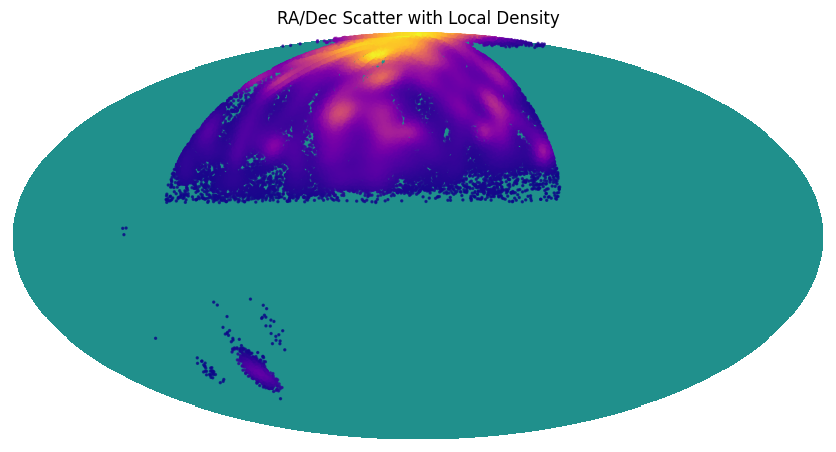

In [73]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from jax.scipy.stats import gaussian_kde

# List of DataFrames (your input)
list_of_dfs = Posteriors_filtered # each df has columns 'ra' and 'dec'

# Create empty arrays to collect sky samples
ras, decs = [], []

# Downsample and collect
for df in list_of_dfs:
    df_sampled = df.sample(n=2000, replace=False)  # downsample to 1000
    ras.extend(df_sampled["ra"].values)
    decs.extend(df_sampled["dec"].values)

ras = xp.array(ras)
decs = xp.array(decs)

# Convert to theta, phi for healpy (theta = colatitude, phi = longitude)
theta = 0.5 * xp.pi - decs  # dec to colatitude
phi = ras  # ra = longitude in radians

x = xp.cos(ras) * np.cos(decs)
y = xp.sin(ras) * np.cos(decs)
z = xp.sin(decs)

xyz = xp.vstack([x, y, z])
kde = gaussian_kde(xyz)

density = kde(xyz)

# Normalize
density = (density - xp.min(density)) / (xp.max(density) - xp.min(density))

# Plot base map
hp.mollview(xp.zeros(12), title="RA/Dec Scatter with Local Density", cbar=False)

# Plot points with density-based color
hp.projscatter(theta, phi, c=density, cmap="plasma", s=2, alpha=0.7)

plt.show()


In [90]:
import bilby as bb
import numpy as np
#iso_result = bb.result.read_in_result('outdir/O3_hyper_test_result.pkl')
#aniso_result = bb.result.read_in_result('outdir/O3a_Px12_result.pkl')
iso_result = bb.result.read_in_result('ANISO_CHECKS_over5/ISO_10th_result.pkl')
aniso_result = bb.result.read_in_result('ANISO_CHECKS_over5/ANISO_10th_result.pkl')

# define log evidences and errors for isotropic / anisotropic models
iso_log_evid, iso_log_evid_err = iso_result.log_evidence, iso_result.log_evidence_err
aniso_log_evid, aniso_log_evid_err = aniso_result.log_evidence, aniso_result.log_evidence_err

Log_BF_iso, Log_BF_aniso = iso_result.log_bayes_factor, aniso_result.log_bayes_factor

BF = np.exp(Log_BF_iso - Log_BF_aniso)

BF_err = BF * np.sqrt(iso_log_evid_err**2 + aniso_log_evid_err**2)

print("The Bayes factor (ISO/ANISO) is", BF, "+/-", BF_err)

The Bayes factor (ISO/ANISO) is 0.14987220930167428 +/- 0.07217805173798778
